In [1]:
# pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
# import neattext.functions as nfx
import matplotlib.pyplot as plt
import regex as re
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, GlobalAveragePooling1D
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import gensim
from sentence_transformers import SentenceTransformer

In [3]:
tf.__version__

'2.9.1'

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [6]:
# df = pd.read_pickle('data_paraphraseMiniLM_L6_v2.pkl')
# df

df = pd.read_pickle('data_paraphraseMultilingualMiniLM_L12_v2.pkl')
df

# df = pd.read_pickle('data_embeddings_bert_without_stopwords.pkl')
# df

,query,L4,L3,L2,L1,q_without_stopwords,embeddings
0,other bath and shower,['MSH2510100105'],['MSH2510100'],['MSH2510'],['MSH25'],bath shower,"[-0.009836546, 0.2023024, 0.30585408, 0.149955..."
1,other bath body,['MSH2510106100'],['MSH2510106'],['MSH2510'],['MSH25'],bath body,"[0.057565857, 0.108061954, 0.32434863, 0.12909..."
2,other bath,"['MSH2510101104', 'MSH2510103105', 'MSH2510103...","['MSH2510106', 'MSH2510102', 'MSH2515104', 'MS...","['MSH2515', 'MSH2510']",['MSH25'],bath,"[0.17068161, 0.095129825, 0.48303428, 0.150357..."
3,other bags,['MSH1607007'],['MSH1607007'],['MSH1607'],['MSH16'],bag,"[0.11405205, 0.51388097, -0.3964267, -0.004697..."
4,other bag,"['MSH1600010', 'MSH2230100', 'MSH1608007']","['MSH2230100', 'MSH1600010', 'MSH1608007']","['MSH1608', 'MSH1600', 'MSH2230']","['MSH22', 'MSH16']",bag,"[0.11405205, 0.51388097, -0.3964267, -0.004697..."
...,...,...,...,...,...,...,...
83290,zunpulse smart home,['MSH1247102'],['MSH1247102'],['MSH1247'],['MSH12'],zunpulse smart home,"[-0.07167591, 0.2624073, -0.33557832, 0.042026..."
83291,zurik shoe,['MSH1311128100'],['MSH1311128'],['MSH1311'],['MSH13'],zurik shoe,"[-0.43181363, 0.097523294, 0.037790015, 0.0241..."
83292,zurik shoes,['MSH1311128100'],['MSH1311128'],['MSH1311'],['MSH13'],zurik shoe,"[-0.43181363, 0.097523294, 0.037790015, 0.0241..."
83293,zzanetti,"['MSH1311115', 'MSH1311112', 'MSH1311127', 'MS...","['MSH1311115', 'MSH1311112', 'MSH1311127', 'MS...",['MSH1311'],['MSH13'],zzanetti,"[-0.2470388, 0.38874525, -0.2468085, 0.1098870..."


In [7]:
def remove_quotes_brackets(x):
    quotes_remove = re.sub("'", "", x)
    brackets_remove = re.sub(r"[\[\]]",'',quotes_remove)
    splitted = brackets_remove.split(',')
    splitted = [x.strip(' ') for x in splitted]
    
    return splitted


df['L4'] = df['L4'].apply(remove_quotes_brackets)

In [8]:
df['L4_count'] = df['L4'].apply(len)

In [9]:
df

,query,L4,L3,L2,L1,q_without_stopwords,embeddings,L4_count
0,other bath and shower,[MSH2510100105],['MSH2510100'],['MSH2510'],['MSH25'],bath shower,"[-0.009836546, 0.2023024, 0.30585408, 0.149955...",1
1,other bath body,[MSH2510106100],['MSH2510106'],['MSH2510'],['MSH25'],bath body,"[0.057565857, 0.108061954, 0.32434863, 0.12909...",1
2,other bath,"[MSH2510101104, MSH2510103105, MSH2510103103, ...","['MSH2510106', 'MSH2510102', 'MSH2515104', 'MS...","['MSH2515', 'MSH2510']",['MSH25'],bath,"[0.17068161, 0.095129825, 0.48303428, 0.150357...",13
3,other bags,[MSH1607007],['MSH1607007'],['MSH1607'],['MSH16'],bag,"[0.11405205, 0.51388097, -0.3964267, -0.004697...",1
4,other bag,"[MSH1600010, MSH2230100, MSH1608007]","['MSH2230100', 'MSH1600010', 'MSH1608007']","['MSH1608', 'MSH1600', 'MSH2230']","['MSH22', 'MSH16']",bag,"[0.11405205, 0.51388097, -0.3964267, -0.004697...",3
...,...,...,...,...,...,...,...,...
83290,zunpulse smart home,[MSH1247102],['MSH1247102'],['MSH1247'],['MSH12'],zunpulse smart home,"[-0.07167591, 0.2624073, -0.33557832, 0.042026...",1
83291,zurik shoe,[MSH1311128100],['MSH1311128'],['MSH1311'],['MSH13'],zurik shoe,"[-0.43181363, 0.097523294, 0.037790015, 0.0241...",1
83292,zurik shoes,[MSH1311128100],['MSH1311128'],['MSH1311'],['MSH13'],zurik shoe,"[-0.43181363, 0.097523294, 0.037790015, 0.0241...",1
83293,zzanetti,"[MSH1311115, MSH1311112, MSH1311127, MSH1311113]","['MSH1311115', 'MSH1311112', 'MSH1311127', 'MS...",['MSH1311'],['MSH13'],zzanetti,"[-0.2470388, 0.38874525, -0.2468085, 0.1098870...",4


In [10]:
len(df['q_without_stopwords'][0].split())

2

In [11]:
df['query_words_count'] = df['q_without_stopwords'].apply(lambda x: len(x.split()))

In [12]:
df = df[['query','L4','L4_count','q_without_stopwords','query_words_count','embeddings','L3','L2','L1']]
df

,query,L4,L4_count,q_without_stopwords,query_words_count,embeddings,L3,L2,L1
0,other bath and shower,[MSH2510100105],1,bath shower,2,"[-0.009836546, 0.2023024, 0.30585408, 0.149955...",['MSH2510100'],['MSH2510'],['MSH25']
1,other bath body,[MSH2510106100],1,bath body,2,"[0.057565857, 0.108061954, 0.32434863, 0.12909...",['MSH2510106'],['MSH2510'],['MSH25']
2,other bath,"[MSH2510101104, MSH2510103105, MSH2510103103, ...",13,bath,1,"[0.17068161, 0.095129825, 0.48303428, 0.150357...","['MSH2510106', 'MSH2510102', 'MSH2515104', 'MS...","['MSH2515', 'MSH2510']",['MSH25']
3,other bags,[MSH1607007],1,bag,1,"[0.11405205, 0.51388097, -0.3964267, -0.004697...",['MSH1607007'],['MSH1607'],['MSH16']
4,other bag,"[MSH1600010, MSH2230100, MSH1608007]",3,bag,1,"[0.11405205, 0.51388097, -0.3964267, -0.004697...","['MSH2230100', 'MSH1600010', 'MSH1608007']","['MSH1608', 'MSH1600', 'MSH2230']","['MSH22', 'MSH16']"
...,...,...,...,...,...,...,...,...,...
83290,zunpulse smart home,[MSH1247102],1,zunpulse smart home,3,"[-0.07167591, 0.2624073, -0.33557832, 0.042026...",['MSH1247102'],['MSH1247'],['MSH12']
83291,zurik shoe,[MSH1311128100],1,zurik shoe,2,"[-0.43181363, 0.097523294, 0.037790015, 0.0241...",['MSH1311128'],['MSH1311'],['MSH13']
83292,zurik shoes,[MSH1311128100],1,zurik shoe,2,"[-0.43181363, 0.097523294, 0.037790015, 0.0241...",['MSH1311128'],['MSH1311'],['MSH13']
83293,zzanetti,"[MSH1311115, MSH1311112, MSH1311127, MSH1311113]",4,zzanetti,1,"[-0.2470388, 0.38874525, -0.2468085, 0.1098870...","['MSH1311115', 'MSH1311112', 'MSH1311127', 'MS...",['MSH1311'],['MSH13']


# Sentence Embedding

In [13]:
# from sentence_transformers import SentenceTransformer
# model11 = SentenceTransformer('all-MiniLM-L6-v2')



# sentences = ['This framework generates embeddings for each input sentence',
#     'Sentences are passed as a list of string.', 
#     'The quick brown fox jumps over the lazy dog.']
# sentence_embeddings = model11.encode(sentences)
# sentence_embeddings










# from sentence_transformers import SentenceTransformer
# model11 = SentenceTransformer('bert-base-nli-mean-tokens')



# sentences = ['This framework generates embeddings for each input sentence',
#     'Sentences are passed as a list of string.', 
#     'The quick brown fox jumps over the lazy dog.']
# sentence_embeddings = model11.encode(sentences)
# sentence_embeddings

# Dropping Data

In [14]:
all_L4 = [j for i in df["L4"] for j in i]
all_L4

['MSH2510100105',
 'MSH2510106100',
 'MSH2510101104',
 'MSH2510103105',
 'MSH2510103103',
 'MSH2510106100',
 'MSH2510103102',
 'MSH2510100105',
 'MSH2510102103',
 'MSH2510104106',
 'MSH2510100100',
 'MSH2510100104',
 'MSH2515104101',
 'MSH2510105102',
 'MSH2510100103',
 'MSH1607007',
 'MSH1600010',
 'MSH2230100',
 'MSH1608007',
 'MSH2515100101',
 'MSH2515100105',
 'MSH2515100108',
 'MSH2515100101',
 'MSH2515104100',
 'MSH2515104101',
 'MSH2515100100',
 'MSH2518101106',
 'MSH2518101105',
 'MSH2518101109',
 'MSH2518101107',
 'MSH2518101102',
 'MSH2518101101',
 'MSH2518101100',
 'MSH2518101104',
 'MSH2518101108',
 'MSH2518101103',
 'MSH1606003',
 'MSH1603002',
 'MSH1606003',
 'MSH1603002',
 'MSH2510102103',
 'MSH2510101104',
 'MSH1116103',
 'MSH2510104106',
 'MSH2510104105',
 'MSH2510104106',
 'MSH2517101104',
 'MSH1607008',
 'MSH2517101104',
 'MSH2513102100',
 'MSH2513102101',
 'MSH2517103101',
 'MSH2517103102',
 'MSH2517100102',
 'MSH2517100102',
 'MSH2517100102',
 'MSH2517102102',
 'MS

In [15]:
len(all_L4)

284000

In [16]:
dict1 = {}

for i in all_L4:
    if i not in dict1:
        dict1[i] = 1
    else:
        dict1[i] += 1

sort_orders = sorted(dict1.items(), key=lambda x: x[1], reverse=True)
sort_orders

[('MSH1016102', 5999),
 ('MSH1012101', 4750),
 ('MSH1016100', 4621),
 ('MSH1311128100', 4394),
 ('MSH1012100', 4008),
 ('MSH1116101', 3377),
 ('MSH1016104', 2856),
 ('MSH1310123100', 2766),
 ('MSH1014106', 2705),
 ('MSH1116100', 2376),
 ('MSH1016103', 2337),
 ('MSH1310113', 2296),
 ('MSH1016108', 2162),
 ('MSH1320101101', 2156),
 ('MSH1311128101', 2131),
 ('MSH1012102', 2093),
 ('MSH1016107', 1923),
 ('MSH1311128109', 1921),
 ('MSH1016101', 1915),
 ('MSH1012103', 1813),
 ('MSH1117100', 1788),
 ('MSH2111104103', 1742),
 ('MSH2111100100', 1739),
 ('MSH1018104', 1696),
 ('MSH1019100', 1691),
 ('MSH1234100', 1679),
 ('MSH1311113', 1637),
 ('MSH1016114', 1622),
 ('MSH1311128102', 1564),
 ('MSH1118104', 1547),
 ('MSH1311128104', 1516),
 ('MSH1320102101', 1490),
 ('MSH1116106', 1467),
 ('MSH1320101102', 1460),
 ('MSH1311115', 1446),
 ('MSH1116107', 1445),
 ('MSH1600010', 1443),
 ('MSH1116105', 1430),
 ('MSH1116103', 1428),
 ('MSH2111102100', 1409),
 ('MSH1500000', 1335),
 ('MSH1016106', 1332)

In [17]:
# sort_orders = sort_orders[:600]
# sort_orders = dict(sort_orders)
# sort_orders

In [18]:
sort_orders = dict(sort_orders)
sort_orders

{'MSH1016102': 5999,
 'MSH1012101': 4750,
 'MSH1016100': 4621,
 'MSH1311128100': 4394,
 'MSH1012100': 4008,
 'MSH1116101': 3377,
 'MSH1016104': 2856,
 'MSH1310123100': 2766,
 'MSH1014106': 2705,
 'MSH1116100': 2376,
 'MSH1016103': 2337,
 'MSH1310113': 2296,
 'MSH1016108': 2162,
 'MSH1320101101': 2156,
 'MSH1311128101': 2131,
 'MSH1012102': 2093,
 'MSH1016107': 1923,
 'MSH1311128109': 1921,
 'MSH1016101': 1915,
 'MSH1012103': 1813,
 'MSH1117100': 1788,
 'MSH2111104103': 1742,
 'MSH2111100100': 1739,
 'MSH1018104': 1696,
 'MSH1019100': 1691,
 'MSH1234100': 1679,
 'MSH1311113': 1637,
 'MSH1016114': 1622,
 'MSH1311128102': 1564,
 'MSH1118104': 1547,
 'MSH1311128104': 1516,
 'MSH1320102101': 1490,
 'MSH1116106': 1467,
 'MSH1320101102': 1460,
 'MSH1311115': 1446,
 'MSH1116107': 1445,
 'MSH1600010': 1443,
 'MSH1116105': 1430,
 'MSH1116103': 1428,
 'MSH2111102100': 1409,
 'MSH1500000': 1335,
 'MSH1016106': 1332,
 'MSH1018100': 1309,
 'MSH1311127': 1302,
 'MSH1311112': 1299,
 'MSH1311128121': 1

In [19]:
len(sort_orders)

1068

In [20]:
c = 0
a=[]
for i in df['L4']:
    for j in i:
        if j not in sort_orders.keys():
            a.append(c)       
    c += 1

In [21]:
a = list(set(a))
len(a)

0

In [22]:
df = df.drop(df.index[a])
df

,query,L4,L4_count,q_without_stopwords,query_words_count,embeddings,L3,L2,L1
0,other bath and shower,[MSH2510100105],1,bath shower,2,"[-0.009836546, 0.2023024, 0.30585408, 0.149955...",['MSH2510100'],['MSH2510'],['MSH25']
1,other bath body,[MSH2510106100],1,bath body,2,"[0.057565857, 0.108061954, 0.32434863, 0.12909...",['MSH2510106'],['MSH2510'],['MSH25']
2,other bath,"[MSH2510101104, MSH2510103105, MSH2510103103, ...",13,bath,1,"[0.17068161, 0.095129825, 0.48303428, 0.150357...","['MSH2510106', 'MSH2510102', 'MSH2515104', 'MS...","['MSH2515', 'MSH2510']",['MSH25']
3,other bags,[MSH1607007],1,bag,1,"[0.11405205, 0.51388097, -0.3964267, -0.004697...",['MSH1607007'],['MSH1607'],['MSH16']
4,other bag,"[MSH1600010, MSH2230100, MSH1608007]",3,bag,1,"[0.11405205, 0.51388097, -0.3964267, -0.004697...","['MSH2230100', 'MSH1600010', 'MSH1608007']","['MSH1608', 'MSH1600', 'MSH2230']","['MSH22', 'MSH16']"
...,...,...,...,...,...,...,...,...,...
83290,zunpulse smart home,[MSH1247102],1,zunpulse smart home,3,"[-0.07167591, 0.2624073, -0.33557832, 0.042026...",['MSH1247102'],['MSH1247'],['MSH12']
83291,zurik shoe,[MSH1311128100],1,zurik shoe,2,"[-0.43181363, 0.097523294, 0.037790015, 0.0241...",['MSH1311128'],['MSH1311'],['MSH13']
83292,zurik shoes,[MSH1311128100],1,zurik shoe,2,"[-0.43181363, 0.097523294, 0.037790015, 0.0241...",['MSH1311128'],['MSH1311'],['MSH13']
83293,zzanetti,"[MSH1311115, MSH1311112, MSH1311127, MSH1311113]",4,zzanetti,1,"[-0.2470388, 0.38874525, -0.2468085, 0.1098870...","['MSH1311115', 'MSH1311112', 'MSH1311127', 'MS...",['MSH1311'],['MSH13']


# X-Features

In [23]:
x_ff1 = []

for i in df['embeddings']:
    x_ff1.append(i)

In [24]:

x_ff1[0]

array([-0.00983655,  0.2023024 ,  0.30585408,  0.14995563,  0.04558314,
        0.28775898,  0.1419071 , -0.35481238,  0.36523026, -0.0054211 ,
       -0.25305074, -0.5876124 , -0.02699284,  0.77244264, -0.19488923,
       -0.4023271 ,  0.5203402 ,  0.44880015, -0.16894512,  0.36937037,
        0.477986  , -0.08396403,  0.11846585, -0.12037663,  0.30950913,
       -0.07348665, -0.23355067, -0.23393525, -0.01058534, -0.55705374,
        0.00243852, -0.42155278,  0.12416103, -0.5802605 ,  0.49165103,
       -0.28878948, -0.33612645,  0.13252026, -0.01269533,  0.23634851,
       -0.00495697,  0.02241502, -0.17144671,  0.19992143,  0.03667296,
        0.40861553,  0.15336238, -0.11290362,  0.20853199,  0.44036725,
        0.5409148 , -0.4348314 ,  0.07166085,  0.07466623, -0.4439942 ,
       -0.10806227,  0.06568123, -0.71772873, -0.14633873,  0.22614762,
       -0.5132727 ,  0.48402607, -0.17238052,  0.53935087, -0.2435634 ,
       -0.0503898 , -0.1999698 ,  0.3331593 ,  0.44122174, -0.50

In [25]:
len(df['embeddings'][0])

384

# Standardisation 

In [26]:
x_ff1[1]

array([ 0.05756586,  0.10806195,  0.32434863,  0.12909569, -0.18880162,
       -0.03585371,  0.5089302 , -0.17803773,  0.10747986,  0.04092909,
       -0.23211662, -0.87786466,  0.12048783,  0.7475899 , -0.19107795,
       -0.43323678,  0.27683914,  0.39328086, -0.1088156 ,  0.34286553,
        0.676594  ,  0.21220642, -0.03906522, -0.22410159, -0.03129346,
       -0.17997861, -0.348738  , -0.05676044,  0.10533753, -0.7387346 ,
       -0.01807658, -0.56444246, -0.3645554 , -0.41883165,  0.44061917,
       -0.28531557, -0.29916653, -0.05520501, -0.2183598 ,  0.20535132,
        0.10899325,  0.24251617, -0.14621918,  0.23856561,  0.3338804 ,
        0.58163446,  0.25740838,  0.14955431,  0.17988577,  0.2958277 ,
        0.52195024, -0.45395955,  0.18201706,  0.21462494, -0.38790387,
        0.26895803, -0.00313559, -0.6522446 , -0.418699  ,  0.18320175,
       -0.27312964,  0.43910336, -0.22983558,  0.4268084 ,  0.06236561,
       -0.31017658, -0.31659964,  0.19044557,  0.2811685 , -0.09

In [27]:
scaler = StandardScaler()

# x_ff1 = scaler.fit_transform(x_ff1)

In [28]:
x_ff1[1]

array([ 0.05756586,  0.10806195,  0.32434863,  0.12909569, -0.18880162,
       -0.03585371,  0.5089302 , -0.17803773,  0.10747986,  0.04092909,
       -0.23211662, -0.87786466,  0.12048783,  0.7475899 , -0.19107795,
       -0.43323678,  0.27683914,  0.39328086, -0.1088156 ,  0.34286553,
        0.676594  ,  0.21220642, -0.03906522, -0.22410159, -0.03129346,
       -0.17997861, -0.348738  , -0.05676044,  0.10533753, -0.7387346 ,
       -0.01807658, -0.56444246, -0.3645554 , -0.41883165,  0.44061917,
       -0.28531557, -0.29916653, -0.05520501, -0.2183598 ,  0.20535132,
        0.10899325,  0.24251617, -0.14621918,  0.23856561,  0.3338804 ,
        0.58163446,  0.25740838,  0.14955431,  0.17988577,  0.2958277 ,
        0.52195024, -0.45395955,  0.18201706,  0.21462494, -0.38790387,
        0.26895803, -0.00313559, -0.6522446 , -0.418699  ,  0.18320175,
       -0.27312964,  0.43910336, -0.22983558,  0.4268084 ,  0.06236561,
       -0.31017658, -0.31659964,  0.19044557,  0.2811685 , -0.09

# Y_Labels

In [29]:
# def remove_quotes_brackets(x):
#     quotes_remove = re.sub("'", "", x)
#     brackets_remove = re.sub(r"[\[\]]",'',quotes_remove)
#     splitted = brackets_remove.split(',')
#     splitted = [x.strip(' ') for x in splitted]
    
#     return splitted

In [30]:
# df['L4'] = df['L4'].apply(remove_quotes_brackets)

In [31]:
df['L4']

0                                          [MSH2510100105]
1                                          [MSH2510106100]
2        [MSH2510101104, MSH2510103105, MSH2510103103, ...
3                                             [MSH1607007]
4                     [MSH1600010, MSH2230100, MSH1608007]
                               ...                        
83290                                         [MSH1247102]
83291                                      [MSH1311128100]
83292                                      [MSH1311128100]
83293     [MSH1311115, MSH1311112, MSH1311127, MSH1311113]
83294                 [MSH1311115, MSH1311112, MSH1311113]
Name: L4, Length: 83295, dtype: object

In [32]:
# type(df['L4'][2])

In [33]:
# df['L4'][2]

In [34]:
df

,query,L4,L4_count,q_without_stopwords,query_words_count,embeddings,L3,L2,L1
0,other bath and shower,[MSH2510100105],1,bath shower,2,"[-0.009836546, 0.2023024, 0.30585408, 0.149955...",['MSH2510100'],['MSH2510'],['MSH25']
1,other bath body,[MSH2510106100],1,bath body,2,"[0.057565857, 0.108061954, 0.32434863, 0.12909...",['MSH2510106'],['MSH2510'],['MSH25']
2,other bath,"[MSH2510101104, MSH2510103105, MSH2510103103, ...",13,bath,1,"[0.17068161, 0.095129825, 0.48303428, 0.150357...","['MSH2510106', 'MSH2510102', 'MSH2515104', 'MS...","['MSH2515', 'MSH2510']",['MSH25']
3,other bags,[MSH1607007],1,bag,1,"[0.11405205, 0.51388097, -0.3964267, -0.004697...",['MSH1607007'],['MSH1607'],['MSH16']
4,other bag,"[MSH1600010, MSH2230100, MSH1608007]",3,bag,1,"[0.11405205, 0.51388097, -0.3964267, -0.004697...","['MSH2230100', 'MSH1600010', 'MSH1608007']","['MSH1608', 'MSH1600', 'MSH2230']","['MSH22', 'MSH16']"
...,...,...,...,...,...,...,...,...,...
83290,zunpulse smart home,[MSH1247102],1,zunpulse smart home,3,"[-0.07167591, 0.2624073, -0.33557832, 0.042026...",['MSH1247102'],['MSH1247'],['MSH12']
83291,zurik shoe,[MSH1311128100],1,zurik shoe,2,"[-0.43181363, 0.097523294, 0.037790015, 0.0241...",['MSH1311128'],['MSH1311'],['MSH13']
83292,zurik shoes,[MSH1311128100],1,zurik shoe,2,"[-0.43181363, 0.097523294, 0.037790015, 0.0241...",['MSH1311128'],['MSH1311'],['MSH13']
83293,zzanetti,"[MSH1311115, MSH1311112, MSH1311127, MSH1311113]",4,zzanetti,1,"[-0.2470388, 0.38874525, -0.2468085, 0.1098870...","['MSH1311115', 'MSH1311112', 'MSH1311127', 'MS...",['MSH1311'],['MSH13']


In [35]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()


y_label = mlb.fit_transform(df['L4'])

In [36]:
mlb.classes_

array(['ISH1010100100', 'ISH1010101105', 'MPH1110100', ...,
       'MSH2518105103', 'MSH2610100100', 'MSH2710100'], dtype=object)

In [37]:
# for i in mlb.classes_:
#     print(i)

In [38]:
# y_label[83000]

In [39]:
len(y_label[1])

1068

In [40]:
np.unique(list(y_label))

array([0, 1])

In [41]:
np.array(x_ff1)

array([[-0.00983655,  0.2023024 ,  0.30585408, ...,  0.10094354,
        -0.36732072, -0.09453354],
       [ 0.05756586,  0.10806195,  0.32434863, ...,  0.0805252 ,
        -0.21836402, -0.03939155],
       [ 0.17068161,  0.09512983,  0.48303428, ...,  0.11023629,
        -0.27100235,  0.0262778 ],
       ...,
       [-0.43181363,  0.09752329,  0.03779002, ..., -0.34015605,
        -0.17360853,  0.22853911],
       [-0.2470388 ,  0.38874525, -0.2468085 , ...,  0.03633942,
         0.0310733 , -0.04610754],
       [-0.4319717 ,  0.37117717, -0.07301729, ..., -0.1876154 ,
        -0.14178635,  0.19811146]], dtype=float32)

In [42]:
y_label

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Data

In [43]:
df

,query,L4,L4_count,q_without_stopwords,query_words_count,embeddings,L3,L2,L1
0,other bath and shower,[MSH2510100105],1,bath shower,2,"[-0.009836546, 0.2023024, 0.30585408, 0.149955...",['MSH2510100'],['MSH2510'],['MSH25']
1,other bath body,[MSH2510106100],1,bath body,2,"[0.057565857, 0.108061954, 0.32434863, 0.12909...",['MSH2510106'],['MSH2510'],['MSH25']
2,other bath,"[MSH2510101104, MSH2510103105, MSH2510103103, ...",13,bath,1,"[0.17068161, 0.095129825, 0.48303428, 0.150357...","['MSH2510106', 'MSH2510102', 'MSH2515104', 'MS...","['MSH2515', 'MSH2510']",['MSH25']
3,other bags,[MSH1607007],1,bag,1,"[0.11405205, 0.51388097, -0.3964267, -0.004697...",['MSH1607007'],['MSH1607'],['MSH16']
4,other bag,"[MSH1600010, MSH2230100, MSH1608007]",3,bag,1,"[0.11405205, 0.51388097, -0.3964267, -0.004697...","['MSH2230100', 'MSH1600010', 'MSH1608007']","['MSH1608', 'MSH1600', 'MSH2230']","['MSH22', 'MSH16']"
...,...,...,...,...,...,...,...,...,...
83290,zunpulse smart home,[MSH1247102],1,zunpulse smart home,3,"[-0.07167591, 0.2624073, -0.33557832, 0.042026...",['MSH1247102'],['MSH1247'],['MSH12']
83291,zurik shoe,[MSH1311128100],1,zurik shoe,2,"[-0.43181363, 0.097523294, 0.037790015, 0.0241...",['MSH1311128'],['MSH1311'],['MSH13']
83292,zurik shoes,[MSH1311128100],1,zurik shoe,2,"[-0.43181363, 0.097523294, 0.037790015, 0.0241...",['MSH1311128'],['MSH1311'],['MSH13']
83293,zzanetti,"[MSH1311115, MSH1311112, MSH1311127, MSH1311113]",4,zzanetti,1,"[-0.2470388, 0.38874525, -0.2468085, 0.1098870...","['MSH1311115', 'MSH1311112', 'MSH1311127', 'MS...",['MSH1311'],['MSH13']


In [44]:
df[df['L4_count'] == df['L4_count'].max()]

,query,L4,L4_count,q_without_stopwords,query_words_count,embeddings,L3,L2,L1
70,others,"[MSH1605002, MSH2234107, MSH1605008, MSH223010...",403,others,1,"[0.36899838, -0.31718576, -0.102538325, 0.0059...","['MSH1605002', 'MSH2234107', 'MSH1605008', 'MS...","['MSH2215', 'MSH1605', 'MSH1253', 'MSH1231', '...","['MSH12', 'MSH16', 'MSH26', 'MSH20', 'MSH13', ..."


# Split, Train & Test

In [45]:
np.shape(np.array(x_ff1))

(83295, 384)

In [47]:
x_train,x_test,y_train,y_test = train_test_split(np.array(x_ff1), y_label, test_size=0.20, random_state=42)

In [48]:
y_train.shape

(66636, 1068)

#### Working

In [47]:
# # vocab_size = 50
# # max_length=5

# model = tf.keras.models.Sequential([
# #     tf.keras.layers.Embedding(vocab_size, 50, input_length=max_length),
# #     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(500, activation='relu',kernel_initializer='he_uniform',input_shape=(384,)),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(800, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(1000, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(1400, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(1800, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(2000, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')

# ])

# model.compile(
#     loss = 'binary_crossentropy',
# #     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
# #     metrics=['precision']
#     metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
# )

# model.summary()

#### Testing CNN

In [48]:
# # vocab_size = 50
# # max_length=5

# model = tf.keras.models.Sequential([
# #     tf.keras.layers.Embedding(vocab_size, 50, input_length=max_length),
# #     tf.keras.layers.Flatten(),
#     tf.keras.layers.Embedding(500, 50, input_length=384),
#     tf.keras.layers.Conv1D(800, 5, activation='relu'),
#     tf.keras.layers.GlobalMaxPooling1D(),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(1000, activation='relu',kernel_initializer='glorot_uniform'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(1200, activation='relu',kernel_initializer='glorot_uniform'),
#     tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')

# ])

# model.compile(
#     loss='binary_crossentropy',
# #     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     metrics=['accuracy']
# )

# model.summary()





# # Stuck at 3% when using CNN layers

#### Testing ANN 1

In [49]:
# # vocab_size = 50
# # max_length=5

# model = tf.keras.models.Sequential([
# #     tf.keras.layers.Embedding(vocab_size, 50, input_length=max_length),
# #     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(384, activation='relu',kernel_initializer='he_uniform',input_shape=(384,)),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(500, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(1000, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(1500, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dense(2000, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')

# ])

# model.compile(
#     loss='binary_crossentropy',
# #     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     metrics=['accuracy']
# )

# model.summary()



# # with all-MiniLM-L6-v2 stuck on 62% with 47% validation acc. at 200 epochs

#### Testing ANN 2

In [50]:
# # vocab_size = 50
# # max_length=5

# model = tf.keras.models.Sequential([
# #     tf.keras.layers.Embedding(vocab_size, 50, input_length=max_length),
# #     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(384, activation='relu',kernel_initializer='he_uniform',input_shape=(384,)),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(2000, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')

# ])

# model.compile(
#     loss='binary_crossentropy',
# #     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     metrics=['accuracy']
# )

# model.summary()



# # with all-MiniLM-L6-v2 stuck on 62% with 47% validation acc. at 400 epochs

#### Testing ANN 3

In [51]:
# # vocab_size = 50
# # max_length=5

# model = tf.keras.models.Sequential([
# #     tf.keras.layers.Embedding(vocab_size, 50, input_length=max_length),
# #     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(384, activation='relu',kernel_initializer='he_uniform',input_shape=(384,)),
#     tf.keras.layers.Dropout(0.05),
#     tf.keras.layers.Dense(500, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.05),
#     tf.keras.layers.Dense(1000, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.05),
#     tf.keras.layers.Dense(1500, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dense(2000, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')

# ])

# model.compile(
#     loss='binary_crossentropy',
# #     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     metrics=['accuracy']
# )

# model.summary()



# # with all-MiniLM-L6-v2 stuck on 62% with 47% validation acc. at 100 epochs

#### Testing ANN 4

In [52]:
# # vocab_size = 50
# # max_length=5

# model = tf.keras.models.Sequential([
# #     tf.keras.layers.Embedding(vocab_size, 50, input_length=max_length),
# #     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(384, activation='relu',kernel_initializer='he_uniform',input_shape=(384,)),
#     tf.keras.layers.Dropout(0.01),
#     tf.keras.layers.Dense(500, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.01),
#     tf.keras.layers.Dense(1000, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.01),
#     tf.keras.layers.Dense(1500, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dense(2000, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')

# ])

# model.compile(
#     loss='binary_crossentropy',
# #     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     metrics=['accuracy']
# )

# model.summary()



# # with all-MiniLM-L6-v2 stuck on 64% with 47% validation acc. at 100 epochs

#### Testing ANN 5

In [53]:
# # vocab_size = 50
# # max_length=5

# model = tf.keras.models.Sequential([
# #     tf.keras.layers.Embedding(vocab_size, 50, input_length=max_length),
# #     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(500, activation='relu',kernel_initializer='he_uniform',input_shape=(384,)),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(800, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(1000, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(1400, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(1800, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(2000, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')

# ])

# model.compile(
#     loss='binary_crossentropy',
# #     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     metrics=['accuracy']
# )

# model.summary()



# # with all-MiniLM-L6-v2 stuck on 63% with 45% validation acc. at 100 epochs

### Test ANN 6

In [54]:
# # vocab_size = 50
# # max_length=5

# model = tf.keras.models.Sequential([
# #     tf.keras.layers.Embedding(vocab_size, 50, input_length=max_length),
# #     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(500, activation='relu',kernel_initializer='he_uniform',input_shape=(384,)),
# #     tf.keras.layers.Dropout(0.15),
#     tf.keras.layers.Dense(1000, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.16),
#     tf.keras.layers.Dense(1500, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.16),
#     tf.keras.layers.Dense(1000, activation='relu',kernel_initializer='he_uniform'),
# #     tf.keras.layers.Dropout(0.2),
# #     tf.keras.layers.Dense(1000, activation='relu',kernel_initializer='he_uniform'),
# #     tf.keras.layers.Dropout(0.15),
# #     tf.keras.layers.Dense(2000, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')

# ])

# model.compile(
#     loss = 'binary_crossentropy',
# #     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
#     metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
# )

# model.summary()

# Test ANN 7

In [55]:
# vocab_size = 50
# max_length=5

model = tf.keras.models.Sequential([
#     tf.keras.layers.Embedding(vocab_size, 50, input_length=max_length),
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation='relu',kernel_initializer='he_uniform',input_shape=(384,)),
#     tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(1000, activation='relu',kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2000, activation='relu',kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2000, activation='relu',kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1200, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1000, activation='relu',kernel_initializer='he_uniform'),
#     tf.keras.layers.Dropout(0.15),
#     tf.keras.layers.Dense(2000, activation='relu',kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')

])

model.compile(
    loss = 'binary_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               192500    
                                                                 
 dense_1 (Dense)             (None, 1000)              501000    
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 2000)              2002000   
                                                                 
 dropout_1 (Dropout)         (None, 2000)              0         
                                                                 
 dense_3 (Dense)             (None, 2000)              4002000   
                                                                 
 dropout_2 (Dropout)         (None, 2000)              0

In [58]:
history = model.fit(
    x_train, y_train,
    epochs=300,
    verbose=1,
    batch_size=512,
    validation_split=0.4
    )

Epoch 1/300
83/83 [==============================] - 28s 336ms/step - loss: 4.2751e-04 - accuracy: 0.7478 - precision: 0.9709 - recall: 0.9613 - val_loss: 0.0272 - val_accuracy: 0.4932 - val_precision: 0.6809 - val_recall: 0.5361
Epoch 2/300
83/83 [==============================] - 30s 368ms/step - loss: 4.5592e-04 - accuracy: 0.7401 - precision: 0.9703 - recall: 0.9591 - val_loss: 0.0273 - val_accuracy: 0.4921 - val_precision: 0.6865 - val_recall: 0.5347
Epoch 3/300
83/83 [==============================] - 29s 353ms/step - loss: 4.5238e-04 - accuracy: 0.7498 - precision: 0.9712 - recall: 0.9586 - val_loss: 0.0264 - val_accuracy: 0.4901 - val_precision: 0.6754 - val_recall: 0.5432
Epoch 4/300
83/83 [==============================] - 30s 367ms/step - loss: 4.4182e-04 - accuracy: 0.7420 - precision: 0.9689 - recall: 0.9600 - val_loss: 0.0267 - val_accuracy: 0.4792 - val_precision: 0.6874 - val_recall: 0.5340
Epoch 5/300
83/83 [==============================] - 29s 350ms/step - loss: 4.28

In [59]:
hss = history.history

Text(0.5, 1.0, 'Accuracy vs Epochs')

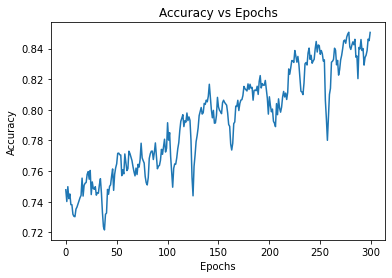

In [60]:
import matplotlib.pyplot as plt
plt.plot(hss['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')

Text(0.5, 1.0, 'Loss vs Epochs')

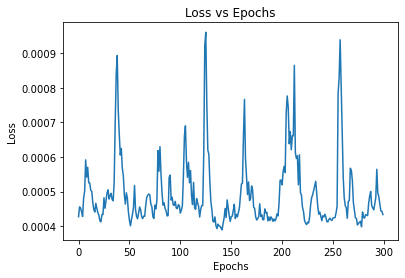

In [61]:
plt.plot(hss['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')

Text(0.5, 1.0, 'val_acc vs Epochs')

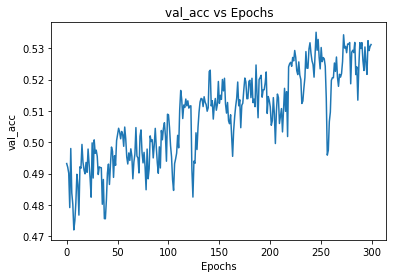

In [62]:
plt.plot(hss['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('val_acc')
plt.title('val_acc vs Epochs')

-------------------------------------------------------------------------------------------------------------------------------

In [63]:
yhat = model.predict(x_test)
# round probabilities to class labels
yhat = yhat.round()
# calculate accuracy
acc = accuracy_score(y_test, yhat)
acc

391/391 [==============================] - 8s 17ms/step


0.45754301720688273

In [64]:
yhat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Predictions Test

In [65]:
model_for_encoding_query = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [64]:
L4_mapping = pd.read_json('msh_cat_mapping(1).json').reset_index()
L4_mapping.columns = ['L4','level1', 'level2', 'level3', 'level4']

In [65]:
classes_index = {i: key for i, key in enumerate(mlb.classes_)}
classes_index

{0: 'ISH1010100100',
 1: 'ISH1010101105',
 2: 'MPH1110100',
 3: 'MPH1110101',
 4: 'MSH1012100',
 5: 'MSH1012101',
 6: 'MSH1012102',
 7: 'MSH1012103',
 8: 'MSH1012104',
 9: 'MSH1012105',
 10: 'MSH1014100',
 11: 'MSH1014101',
 12: 'MSH1014102',
 13: 'MSH1014103',
 14: 'MSH1014104',
 15: 'MSH1014105',
 16: 'MSH1014106',
 17: 'MSH1014107',
 18: 'MSH1014108',
 19: 'MSH1014112',
 20: 'MSH1014113',
 21: 'MSH1015106',
 22: 'MSH1016100',
 23: 'MSH1016101',
 24: 'MSH1016102',
 25: 'MSH1016103',
 26: 'MSH1016104',
 27: 'MSH1016105',
 28: 'MSH1016106',
 29: 'MSH1016107',
 30: 'MSH1016108',
 31: 'MSH1016109',
 32: 'MSH1016110',
 33: 'MSH1016112',
 34: 'MSH1016113',
 35: 'MSH1016114',
 36: 'MSH1017100',
 37: 'MSH1017101',
 38: 'MSH1017102',
 39: 'MSH1017103',
 40: 'MSH1017104',
 41: 'MSH1018100',
 42: 'MSH1018101',
 43: 'MSH1018102',
 44: 'MSH1018103',
 45: 'MSH1018104',
 46: 'MSH1018105',
 47: 'MSH1019100',
 48: 'MSH1019101',
 49: 'MSH1112101',
 50: 'MSH1112102',
 51: 'MSH1112108',
 52: 'MSH1112109

In [66]:
pred_test = np.argsort(model.predict(model_for_encoding_query.encode('airpods').reshape(1,384))[0])[::-1][:5]
for i in pred_test:
    print('L4 :- ',classes_index[i],', Category :- ',list(L4_mapping[L4_mapping['L4'] == classes_index[i]].level4)[0])

L4 :-  MSH1234100 , Category :-  earphones
L4 :-  MSH1234101 , Category :-  headsets
L4 :-  MSH1222101 , Category :-  covers & cases
L4 :-  MSH1221107 , Category :-  gaming headphones
L4 :-  MSH1222103 , Category :-  power bank


In [67]:
model.predict(model_for_encoding_query.encode('airpods').reshape(1,384))[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [68]:
predict_prob=model.predict(x_test[:3])

predict_classes=np.argmax(predict_prob,axis=1)
predict_classes

array([ 24, 322,   5], dtype=int64)

In [69]:
pred_test = np.argsort(model.predict(model_for_encoding_query.encode('light').reshape(1,384))[0])[::-1][:10]
for i in pred_test:
    print('L4 :- ',classes_index[i],', Category :- ',list(L4_mapping[L4_mapping['L4'] == classes_index[i]].level4)[0])

L4 :-  MSH2216101 , Category :-  decorative lights
L4 :-  MSH2216104 , Category :-  study table lamps
L4 :-  MSH2216103 , Category :-  lamp shades
L4 :-  MSH2216100 , Category :-  chandeliers
L4 :-  MSH2216108 , Category :-  bulbs
L4 :-  MSH2216102 , Category :-  floor lamps
L4 :-  MSH2216107 , Category :-  ceiling lights
L4 :-  MSH2216106 , Category :-  wall lights
L4 :-  MSH2216105 , Category :-  table lamps
L4 :-  MSH1116101 , Category :-  shirts


In [70]:
a = np.sort(model.predict(model_for_encoding_query.encode('light').reshape(1,384))[0][::-1])
a

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [71]:
b = np.percentile(a, 50)
b

0.0

In [72]:
c = []
for i in a:
    if i > b:
        c.append(i)   

d = []
for i in c:
    if i > (sum(c) / len(c)):
        d.append(i)

d

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

### Function for Prediction

In [73]:
model_for_encoding_query = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [74]:
L4_mapping = pd.read_json('msh_cat_mapping(1).json').reset_index()
L4_mapping.columns = ['L4','level1', 'level2', 'level3', 'level4']

In [75]:
classes_index = {i: key for i, key in enumerate(mlb.classes_)}
classes_index

{0: 'ISH1010100100',
 1: 'ISH1010101105',
 2: 'MPH1110100',
 3: 'MPH1110101',
 4: 'MSH1012100',
 5: 'MSH1012101',
 6: 'MSH1012102',
 7: 'MSH1012103',
 8: 'MSH1012104',
 9: 'MSH1012105',
 10: 'MSH1014100',
 11: 'MSH1014101',
 12: 'MSH1014102',
 13: 'MSH1014103',
 14: 'MSH1014104',
 15: 'MSH1014105',
 16: 'MSH1014106',
 17: 'MSH1014107',
 18: 'MSH1014108',
 19: 'MSH1014112',
 20: 'MSH1014113',
 21: 'MSH1015106',
 22: 'MSH1016100',
 23: 'MSH1016101',
 24: 'MSH1016102',
 25: 'MSH1016103',
 26: 'MSH1016104',
 27: 'MSH1016105',
 28: 'MSH1016106',
 29: 'MSH1016107',
 30: 'MSH1016108',
 31: 'MSH1016109',
 32: 'MSH1016110',
 33: 'MSH1016112',
 34: 'MSH1016113',
 35: 'MSH1016114',
 36: 'MSH1017100',
 37: 'MSH1017101',
 38: 'MSH1017102',
 39: 'MSH1017103',
 40: 'MSH1017104',
 41: 'MSH1018100',
 42: 'MSH1018101',
 43: 'MSH1018102',
 44: 'MSH1018103',
 45: 'MSH1018104',
 46: 'MSH1018105',
 47: 'MSH1019100',
 48: 'MSH1019101',
 49: 'MSH1112101',
 50: 'MSH1112102',
 51: 'MSH1112108',
 52: 'MSH1112109

In [76]:
def get_L4_predictions(input_query):
    
    category_preds = []
    
    get_pred_query = np.sort(model.predict(model_for_encoding_query.encode(input_query).reshape(1,384))[0][::-1])

    pred_thres = np.percentile(get_pred_query, 90)

    above_thres = [i for i in get_pred_query if i > pred_thres]

    above_avg = [i for i in above_thres if i > (sum(above_thres) / len(above_thres))]

    pred_test = np.argsort(model.predict(model_for_encoding_query.encode(input_query).reshape(1,384))[0])[::-1][:len(above_avg)]
    
    for i in pred_test:
        L4_num = classes_index[i]
        L4_cat = list(L4_mapping[L4_mapping['L4'] == classes_index[i]].level4)[0]
        L3_num = classes_index[i][:10]
        L3_cat = list(L4_mapping[L4_mapping['L4'] == classes_index[i][:10]].level3)[0]
        L2_num = classes_index[i][:7]
        L2_cat = list(L4_mapping[L4_mapping['L4'] == classes_index[i][:7]].level2)[0]
        L1_num = classes_index[i][:5]
        L1_cat = list(L4_mapping[L4_mapping['L4'] == classes_index[i][:5]].level1)[0]
        
#         category_preds.append('L4 :- ' + str(L4_num) + ', Category :- ' + str(L4_cat) + ', L3 :- ' + str(L3_num) + ', Category :- ' + str(L3_cat) + ', L2 :- ' + str(L2_num) + ', Category :- ' + str(L2_cat) + ', L1 :- ' + str(L1_cat) + ', Category :- ' + str(L1_cat))
        category_preds.append({'Query':input_query,'L4':L4_num,'L4_cat':L4_cat, 'L3':L3_num,'L3_cat':L3_cat, 'L2':L2_num,'L2_cat':L2_cat, 'L1':L1_num,'L1_cat':L1_cat})
    
    return category_preds

In [83]:
for i in get_L4_predictions('laptop'):
    print(i)
    print()

{'Query': 'laptop', 'L4': 'MSH1223101', 'L4_cat': '2-in-1', 'L3': 'MSH1223101', 'L3_cat': '2-in-1', 'L2': 'MSH1223', 'L2_cat': 'laptop', 'L1': 'MSH12', 'L1_cat': 'electronics'}

{'Query': 'laptop', 'L4': 'MSH1223100', 'L4_cat': 'notebook & macbook', 'L3': 'MSH1223100', 'L3_cat': 'notebook & macbook', 'L2': 'MSH1223', 'L2_cat': 'laptop', 'L1': 'MSH12', 'L1_cat': 'electronics'}



In [78]:
for i in df['query'].sample(10):
    for j in get_L4_predictions(i):
        print(j)
        print()
        
    print()
    print()
    print()

{'Query': 'oil dispenser', 'L4': 'MSH2235100', 'L4_cat': 'oil dispenser', 'L3': 'MSH2235100', 'L3_cat': 'oil dispenser', 'L2': 'MSH2235', 'L2_cat': 'kitchen storage containers', 'L1': 'MSH22', 'L1_cat': 'home'}




{'Query': 'white kurti for women', 'L4': 'MSH1012100', 'L4_cat': 'kurtis & kurtas', 'L3': 'MSH1012100', 'L3_cat': 'kurtis & kurtas', 'L2': 'MSH1012', 'L2_cat': 'ethnic wear', 'L1': 'MSH10', 'L1_cat': "women's clothing"}




{'Query': 'puma flyer flex', 'L4': 'MSH1311128100', 'L4_cat': 'running', 'L3': 'MSH1311128', 'L3_cat': 'sports shoes', 'L2': 'MSH1311', 'L2_cat': 'men', 'L1': 'MSH13', 'L1_cat': 'footwear'}

{'Query': 'puma flyer flex', 'L4': 'MSH1310123100', 'L4_cat': 'running', 'L3': 'MSH1310123', 'L3_cat': 'sports shoes', 'L2': 'MSH1310', 'L2_cat': 'women', 'L1': 'MSH13', 'L1_cat': 'footwear'}




{'Query': 'razors blade', 'L4': 'MSH2515102104', 'L4_cat': 'razors & cartridges', 'L3': 'MSH2515102', 'L3_cat': 'mens shaving', 'L2': 'MSH2515', 'L2_cat': 'mens grooming', 'L

In [ ]:
# y_test_arg = np.argmax(y_test, axis=1)

# y_pred = np.argmax(model.predict(x_test), axis=1)

# print('Classification Report')

# print(classification_report(y_test_arg, y_pred))

In [ ]:
# from sklearn.metrics import precision_score, recall_score

# print(precision_score(y_test_arg, y_pred, average='weighted'))
# print(recall_score(y_test_arg, y_pred, average='weighted'))

In [ ]:
# from sklearn.metrics import f1_score

# print(f1_score(y_test_arg, y_pred, average='weighted'))